# Danish fire insurance data

In [2]:
%run preamble_notebooks.py
danish = pd.read_csv("../Data/Danish/danish.csv").x
from graph_methods import *

## Descriptive statistics

In [3]:
print(danish.describe().to_latex(float_format="%.2f"))

\begin{tabular}{lr}
\toprule
{} &       x \\
\midrule
count & 2492.00 \\
mean  &    3.06 \\
std   &    7.98 \\
min   &    0.31 \\
25\%   &    1.16 \\
50\%   &    1.63 \\
75\%   &    2.65 \\
max   &  263.25 \\
\bottomrule
\end{tabular}



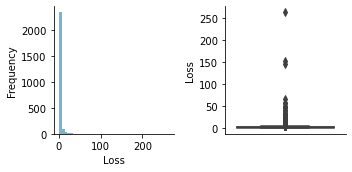

In [4]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(5, 2.5))
num_bins = 40
# the histogram of the data
n, bins, patches = axs[0].hist(danish, num_bins, alpha=0.5, color = '#006699')

g = sns.boxplot(ax = axs[1], data = danish)
for i,box in enumerate(g.artists):
        box.set_facecolor('#006699')
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Frequency")
axs[1].set_ylabel("Loss")
axs[1].set_xticks([])
# plt.show()
sns.despine()
plt.savefig("../../SMCLoMo/Figures/hist_boxplot_danish_en.pdf")

In [7]:
threshold = pd.read_csv("../Data/Danish/tea_threshold.csv")
print(threshold[["threshold", "method"]].to_latex(float_format="%.2f"))

\begin{tabular}{lrl}
\toprule
{} &  threshold &                                     method \\
\midrule
0 &       2.46 &                      AMSE Caeiro and Gomes \\
1 &      14.39 &                         Drees and Kauffman \\
2 &      25.29 &                      eye Danielsson et al. \\
3 &       4.61 &  Gerstengarbe plot Gerstengarbe and Werner \\
4 &      12.06 &                  exp test Guillou and Hall \\
5 &       1.43 &               double bootsrap Gomes et al. \\
6 &       4.09 &                      Single bootstrap Hall \\
7 &       1.50 &                             Hall and Welsh \\
\bottomrule
\end{tabular}



## Importation of the fiting data

In [4]:
import pickle
single_model_df_import = pd.read_csv("../Data/Danish/danish_single_model_fit_.csv").drop(columns = ["Unnamed: 0"], axis = 1)
single_model_df_import["threshold_estimation"] = None
single_model_names = single_model_df_import["model"].values
selec = np.logical_or(np.logical_or(single_model_names == "Lognormal-Pareto", single_model_names == "Gamma-Pareto") ,  single_model_names == "Weibull-Pareto")
threshold_estimation = single_model_df_import["threshold_estimation"].values
threshold_estimation[selec] = "simultaneous"
single_model_df_import["threshold_estimation"] =  threshold_estimation
single_model_df_import["Body"] =  None
single_model_df_import["Tail"] =  None
single_model_df_import["Type"] =  None
with open('../Data/Danish/trace_danish_single_models.obj', 'rb') as fp:
    fit_single_dic_import = pickle.load(fp)
spliced_model_fixed_threshold_df_import = pd.read_csv("../Data/Danish/danish_spliced_models_fixed_threshold.csv").drop(columns = ["Unnamed: 0", "posterior_probability"], axis = 1)
spliced_model_fixed_threshold_df_import["threshold_estimation"] = "fixed"
with open('../Data/Danish/trace_danish_spliced_models_fixed_threshold.obj', 'rb') as fp:
    fit_spliced_fixed_threshold_dic_import = pickle.load(fp)
strip_model_names = pd.DataFrame([np.char.split(spliced_model_fixed_threshold_df_import["model"].values[k], sep = "_").tolist() for k in range(len(spliced_model_fixed_threshold_df_import))])
strip_model_names.columns = ["Body", "Tail", "Type"]
spliced_model_fixed_threshold_df_import = spliced_model_fixed_threshold_df_import.join(strip_model_names)

loss_model_df = pd.concat([single_model_df_import,spliced_model_fixed_threshold_df_import])
fit_loss_model_dic = {**fit_single_dic_import, **fit_spliced_fixed_threshold_dic_import}

loss_models = ["Log-Logistic", "Lomax", "Burr", "Exp", "Gamma", "Weibull", "Inverse-Gaussian", "Lognormal", "Inverse-Weibull", "Inverse-Gamma"]

for loss_model in loss_models:
    spliced_model_df_import = pd.read_csv("../Data/Danish/danish_splicing_model_fit_"+loss_model+".csv").drop(columns = ["Unnamed: 0", "posterior_probability"], axis = 1)
    spliced_model_df_import["threshold_estimation"] = "simultaneous"
    strip_model_names = pd.DataFrame([np.char.split(spliced_model_df_import["model"].values[k], sep = "_").tolist() for k in range(len(spliced_model_df_import))])
    strip_model_names.columns = ["Body", "Tail", "Type"]
    spliced_model_df_import = spliced_model_df_import.join(strip_model_names)

    loss_model_df = pd.concat([loss_model_df, spliced_model_df_import])
    with open("../Data/Danish/trace_danish_"+loss_model+".obj", 'rb') as fp:
        fit_spliced_dic_import = pickle.load(fp)
loss_model_df = loss_model_df.replace("disjoint", "discontinuous")

## Analysis of the composite models with free threshold 

### Goodness of fit comparisons

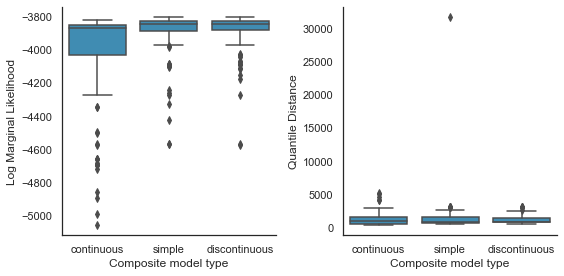

In [5]:
# selec = np.logical_and(np.logical_and(loss_model_df["Type"].values != None, loss_model_df["threshold_estimation"].values == "simultaneous") , loss_model_df["Type"].values != "simple")
selec = np.logical_and(loss_model_df["Type"].values != None, loss_model_df["threshold_estimation"].values == "simultaneous")
sub_df = loss_model_df.iloc[selec].reset_index(drop=True)
sns.set_theme(style="white")
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8,4))
g = sns.boxplot(ax = axs[0], x="Type", y="log_marg", data=loss_model_df.iloc[selec])
g.set(xlabel="Composite model type", ylabel="Log Marginal Likelihood")
for i,box in enumerate(g.artists):
    box.set_facecolor((0, 0.4, 0.6, 0.75))

g = sns.boxplot(ax = axs[1], x="Type", y="Wass_dist", data=loss_model_df.iloc[selec])
g.set(xlabel="Composite model type", ylabel="Quantile Distance")
for i,box in enumerate(g.artists):
    box.set_facecolor((0, 0.4, 0.6, 0.75))
fig.tight_layout()
sns.despine()
plt.savefig("../../SMCLoMo/Figures/boxplot_danish_log_marg_Wass_free_threshold.pdf")

### Combination of models comparisons

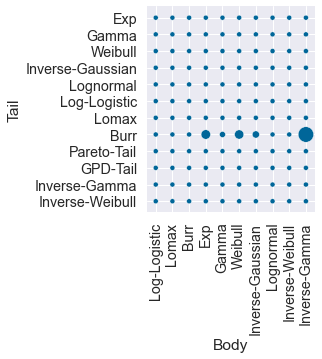

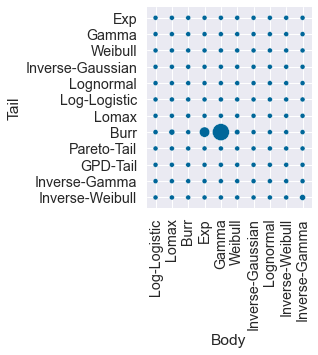

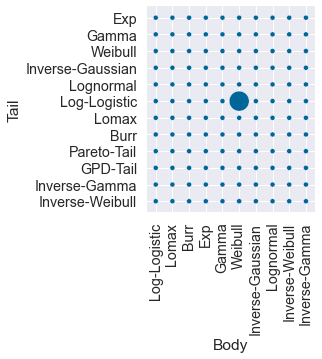

In [6]:
sns.set_theme(style="white")

compo_model_types = ["discontinuous", "simple", "continuous"]
sns.set(font_scale=1.3)
for compo_model_type in compo_model_types:
    
    s = np.logical_and(loss_model_df["Type"].values == compo_model_type, loss_model_df["threshold_estimation"].values == "simultaneous")  
    sub_df = loss_model_df.iloc[s].reset_index(drop=True)
    model_grid(sub_df, "log_marg", 0.01, 0.01)
    # fig.figure(figsize=[5,5])
    fig.tight_layout()
    plt.savefig("../../SMCLoMo/Figures/model_grid_danish_w_"+compo_model_type+"_free_threshold.pdf", bbox_inches='tight')

### Value of the threshold

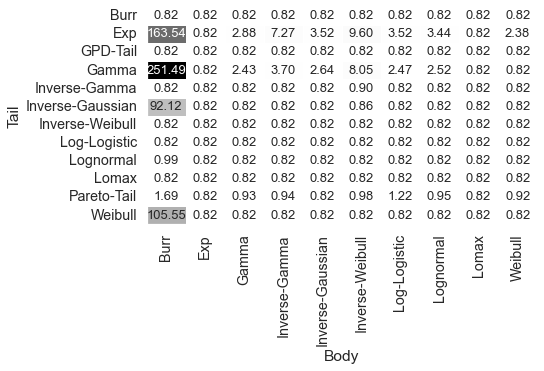

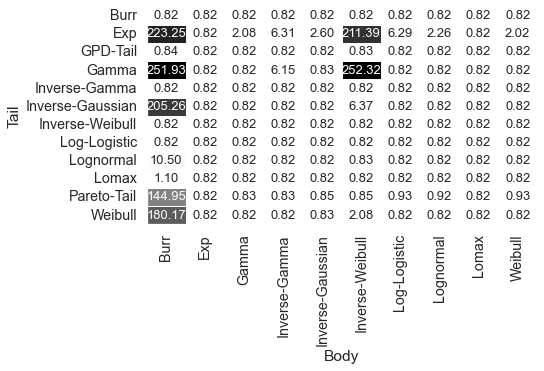

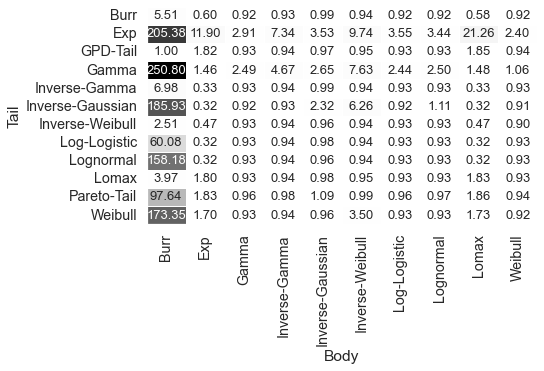

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
sns.set(font_scale=1.3)
pd.options.display.float_format = '{:,.2f}'.format
# Load the example flights dataset and convert to long-form
# flights_long = sns.load_dataset("flights")
compo_model_types = ["discontinuous", "simple", "continuous"]
for compo_model_type in compo_model_types:

    s =  np.logical_and(np.logical_and(loss_model_df["threshold_estimation"].values == "simultaneous", loss_model_df["Body"].values != None), loss_model_df["Type"].values == compo_model_type)
    sub_df = loss_model_df.iloc[s].reset_index(drop=True)
    hm_df = sub_df.pivot("Tail", "Body", "γ_map")
    # hm_df.values
    # # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(7, 4))
    sns.heatmap(hm_df, annot=True, annot_kws={"size": 13}, linewidths=1, fmt='.2f', ax=ax, cmap = "Greys",cbar=False)
    fig.tight_layout()
    sns.despine()
    plt.savefig("../../SMCLoMo/Figures/model_grid_danish_thresh_"+compo_model_type+"_free_threshold.pdf", bbox_inches='tight')

## Posterior plots of Weibull Log logistic continuous versus discontinuous

In [20]:
X = danish.values
f1, f2 = bs.loss_model("Weibull", np.array(["k1", "β1"])), bs.loss_model("Log-Logistic", np.array(["β2", "σ2"]))
f = bs.spliced_loss_model(f1, f2, "continuous")
k1_prior, β1_prior, β2_prior, σ2_prior,  γ_prior  = bs.prior_model("gamma", "k1", 1, 1), bs.prior_model("gamma", "β1", 1, 1), bs.prior_model("gamma", "β2", 1, 1), bs.prior_model("gamma", "σ2", 1, 1), \
bs.prior_model("uniform", "γ", min(X), max(X))
# The smc function deliver the trace, the log marginal likelihood along with some information criteria
prior_spliced_model = bs.independent_priors([k1_prior, β1_prior, β2_prior, σ2_prior,  γ_prior])
popSize = 12000
%time trace, log_marg, DIC, WAIC = bs.smc(X, f, popSize, prior_spliced_model, paralell = True)

Sample generation 0 from the gamma-gamma-gamma-gamma-uniform prior distribution
Generation: 1 ;temperature: 0.00011730194091796875 ;ESS: 6002 ;steps:3 ;particle moved: 99.97500000000001%
Generation: 2 ;temperature: 0.000863985134401446 ;ESS: 5995 ;steps:3 ;particle moved: 99.93333333333332%
Generation: 3 ;temperature: 0.002260514456919843 ;ESS: 6001 ;steps:3 ;particle moved: 99.925%
Generation: 4 ;temperature: 0.004058063899792745 ;ESS: 6003 ;steps:3 ;particle moved: 99.76666666666667%
Generation: 5 ;temperature: 0.005930135065024978 ;ESS: 5999 ;steps:3 ;particle moved: 99.5%
Generation: 6 ;temperature: 0.008730378324566253 ;ESS: 5999 ;steps:3 ;particle moved: 99.47500000000001%
Generation: 7 ;temperature: 0.01410746108611524 ;ESS: 5999 ;steps:3 ;particle moved: 99.73333333333333%
Generation: 8 ;temperature: 0.022549496753733647 ;ESS: 6000 ;steps:3 ;particle moved: 99.79166666666667%
Generation: 9 ;temperature: 0.03441428275033655 ;ESS: 5999 ;steps:3 ;particle moved: 99.80833333333334%

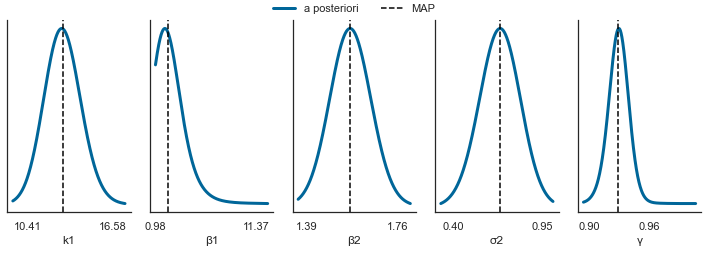

In [21]:
sns.set_theme(style="white")
bs.posterior_plots(f, trace)
plt.savefig("../../SMCLoMo/Figures/posterior_plots_danish_weibull_loglogistic_continuous.pdf", bbox_inches='tight')

In [12]:
X = danish.values
f1, f2 = bs.loss_model("Weibull", np.array(["k1", "β1"])), bs.loss_model("Log-Logistic", np.array(["β2", "σ2"]))
f = bs.spliced_loss_model(f1, f2, "disjoint")
k1_prior, β1_prior, β2_prior, σ2_prior,  γ_prior, p_prior  = bs.prior_model("gamma", "k1", 1, 1), bs.prior_model("gamma", "β1", 1, 1), bs.prior_model("gamma", "β2", 1, 1), bs.prior_model("gamma", "σ2", 1, 1), \
bs.prior_model("uniform", "γ", min(X), max(X)), bs.prior_model("uniform", "p", 0, 1) 
# The smc function deliver the trace, the log marginal likelihood along with some information criteria
prior_spliced_model = bs.independent_priors([k1_prior, β1_prior, β2_prior, σ2_prior,  γ_prior, p_prior])
popSize = 10000
trace, log_marg, DIC, WAIC = bs.smc(X, f, popSize, prior_spliced_model)

Sample generation 0 from the gamma-gamma-gamma-gamma-uniform-uniform prior distribution
Generation: 1 ;temperature: 0.00023746490478515625 ;ESS: 4991 ;steps:3 ;particle moved: 100.0%
Generation: 2 ;temperature: 0.0008086479942903679 ;ESS: 5001 ;steps:3 ;particle moved: 99.99%
Generation: 3 ;temperature: 0.0017724228932379752 ;ESS: 5003 ;steps:3 ;particle moved: 100.0%
Generation: 4 ;temperature: 0.0030425441625991437 ;ESS: 5002 ;steps:3 ;particle moved: 99.99%
Generation: 5 ;temperature: 0.004548009545022035 ;ESS: 5000 ;steps:3 ;particle moved: 99.89%
Generation: 6 ;temperature: 0.006762163207602875 ;ESS: 4998 ;steps:3 ;particle moved: 99.72%
Generation: 7 ;temperature: 0.010967903863409586 ;ESS: 4999 ;steps:3 ;particle moved: 99.77000000000001%
Generation: 8 ;temperature: 0.019520027129087823 ;ESS: 5000 ;steps:3 ;particle moved: 99.78%
Generation: 9 ;temperature: 0.03544487844292783 ;ESS: 5000 ;steps:3 ;particle moved: 99.87%
Generation: 10 ;temperature: 0.05834616507198749 ;ESS: 4999

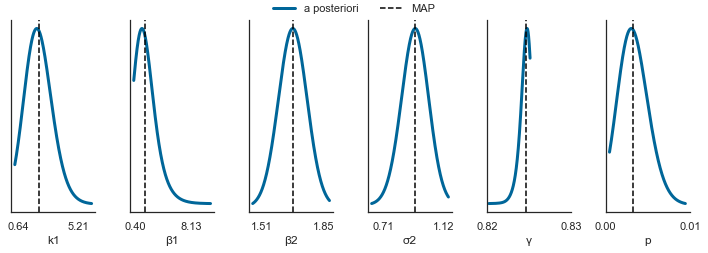

In [13]:
sns.set_theme(style="white")
bs.posterior_plots(f, trace)
plt.savefig("../../SMCLoMo/Figures/posterior_plots_danish_weibull_loglogistic_discontinuous.pdf", bbox_inches='tight')

## Quantile Quantile plot Exponential and Pareto

In [14]:
X = danish.values
f = bs.loss_model("Exp", np.array(["δ"]))
δ_prior = bs.prior_model("gamma", "δ", 1, 1)
# The smc function deliver the trace, the log marginal likelihood along with some information criteria
prior_single_model = bs.independent_priors([δ_prior])
popSize = 10000
trace, log_marg, DIC, WAIC = bs.smc(X, f, popSize, prior_single_model)

Sample generation 0 from the gamma prior distribution
Generation: 1 ;temperature: 0.0008916854858398438 ;ESS: 4999 ;steps:8 ;particle moved: 99.39%
Generation: 2 ;temperature: 0.007613045084781334 ;ESS: 5000 ;steps:7 ;particle moved: 99.22999999999999%
Generation: 3 ;temperature: 0.05682818133884068 ;ESS: 4999 ;steps:7 ;particle moved: 99.49%
Generation: 4 ;temperature: 0.4360009015139643 ;ESS: 4999 ;steps:7 ;particle moved: 99.47%
Generation: 5 ;temperature: 1.0 ;ESS: 8244 ;steps:7 ;particle moved: 99.29%


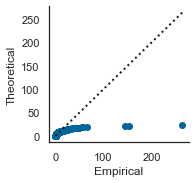

In [15]:
f.set_ppf()
sns.set_theme(style="white")
bs.qq_plot(X, f, trace.mean().values)
plt.savefig("../../SMCLoMo/Figures/qqplot_danish_exp.pdf", bbox_inches='tight')

In [16]:
X = danish.values
f = bs.loss_model("Pareto", np.array(["α", "γ"]))
α_prior, γ_prior  = bs.prior_model("gamma", "α", 1, 1), bs.prior_model("fixed", "γ", min(X), 1)
# The smc function deliver the trace, the log marginal likelihood along with some information criteria
prior_single_model = bs.independent_priors([α_prior, γ_prior])
popSize = 10000
trace, log_marg, DIC, WAIC = bs.smc(X, f, popSize, prior_single_model)

Sample generation 0 from the gamma-fixed prior distribution
Generation: 1 ;temperature: 0.0016145706176757812 ;ESS: 5000 ;steps:6 ;particle moved: 98.91%
Generation: 2 ;temperature: 0.013789830508812884 ;ESS: 5000 ;steps:6 ;particle moved: 99.48%
Generation: 3 ;temperature: 0.10642461829136918 ;ESS: 4999 ;steps:5 ;particle moved: 99.61%
Generation: 4 ;temperature: 0.8070156903724227 ;ESS: 5000 ;steps:6 ;particle moved: 99.39%
Generation: 5 ;temperature: 1.0 ;ESS: 9821 ;steps:6 ;particle moved: 99.45%


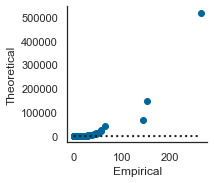

In [17]:
f.set_ppf()
sns.set_theme(style="white")
bs.qq_plot(X, f, trace.mean().values)
plt.savefig("../../SMCLoMo/Figures/qqplot_danish_pareto.pdf", bbox_inches='tight')

In [18]:
X = danish.values
f1, f2 = bs.loss_model("Exp", np.array(["δ"])), bs.loss_model("Pareto-Tail", np.array(["α"]))
f = bs.spliced_loss_model(f1, f2, "continuous")
δ_prior, α_prior, γ_prior  = bs.prior_model("gamma", "δ", 1, 1), bs.prior_model("gamma", "α", 1, 1), bs.prior_model("uniform", "γ", min(X), max(X))
# The smc function deliver the trace, the log marginal likelihood along with some information criteria
prior_spliced_model = bs.independent_priors([δ_prior, α_prior, γ_prior])
popSize = 10000
trace, log_marg, DIC, WAIC = bs.smc(X, f, popSize, prior_spliced_model)

Sample generation 0 from the gamma-gamma-uniform prior distribution
Generation: 1 ;temperature: 9.5367431640625e-07 ;ESS: 3644 ;steps:4 ;particle moved: 99.59%
Generation: 2 ;temperature: 0.0016918174310376344 ;ESS: 4998 ;steps:4 ;particle moved: 99.71%
Generation: 3 ;temperature: 0.006459014008773783 ;ESS: 5000 ;steps:4 ;particle moved: 99.74%
Generation: 4 ;temperature: 0.011275675927422284 ;ESS: 4998 ;steps:4 ;particle moved: 98.53%
Generation: 5 ;temperature: 0.016306394987941036 ;ESS: 4999 ;steps:5 ;particle moved: 98.5%
Generation: 6 ;temperature: 0.025946049876417354 ;ESS: 5000 ;steps:5 ;particle moved: 99.42%
Generation: 7 ;temperature: 0.05263667590436106 ;ESS: 5000 ;steps:3 ;particle moved: 99.13%
Generation: 8 ;temperature: 0.10970226441787723 ;ESS: 4999 ;steps:3 ;particle moved: 99.11999999999999%
Generation: 9 ;temperature: 0.2323265543319124 ;ESS: 5000 ;steps:3 ;particle moved: 99.16%
Generation: 10 ;temperature: 0.49325147735493013 ;ESS: 4999 ;steps:3 ;particle moved: 99

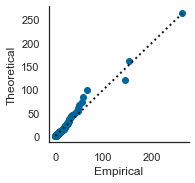

In [19]:
f.set_ppf()
sns.set_theme(style="white")
bs.qq_plot(X, f, trace.mean().values)
plt.savefig("../../SMCLoMo/Figures/qqplot_danish_exp_pareto.pdf", bbox_inches='tight')

(0.5826645264847512, 0.06942215088282504, 1.832212740355069)

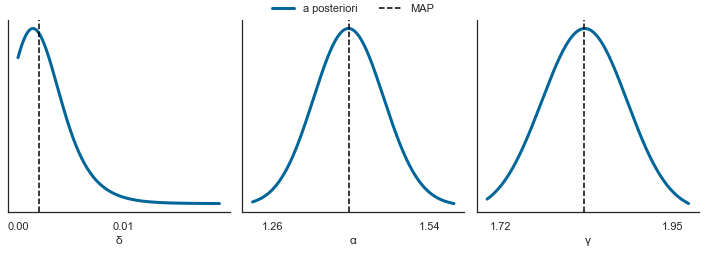

In [28]:
posterior_plots(f, trace)
np.mean(X < trace["γ"].mean()), np.mean(X < 0.93), trace["γ"].mean()

# Fixed threshold

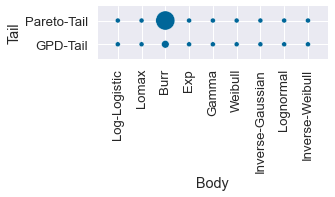

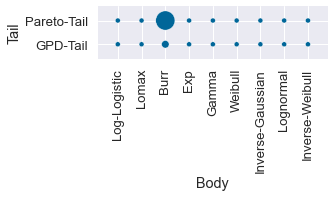

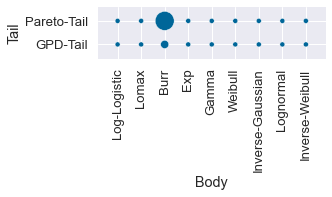

In [71]:
import seaborn as sns
sns.set_theme(style="whitegrid")

compo_model_types = ["discontinuous", "simple", "continuous"]
sns.set(font_scale=1.2)
for compo_model_type in compo_model_types:

    s = np.logical_and(loss_model_df["Type"].values == compo_model_type, loss_model_df["threshold_estimation"].values == "fixed")  
    sub_df = loss_model_df.iloc[s].reset_index(drop=True)
    model_grid(sub_df, "log_marg", 0.05, 0.5)
    fig.tight_layout()
    plt.savefig("../../SMCLoMo/Figures/model_grid_danish_w_"+compo_model_type+"_fixed_threshold.pdf", bbox_inches='tight')

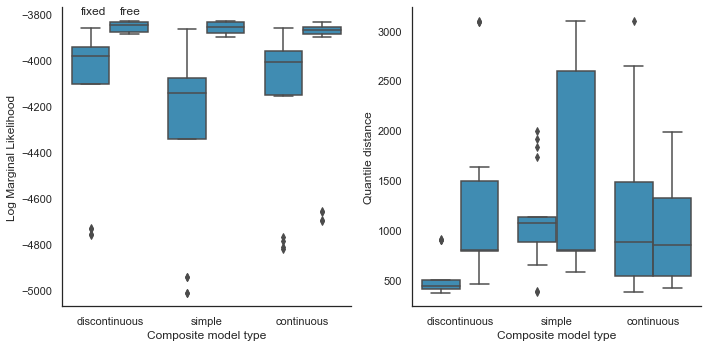

In [69]:
# selec = np.logical_and(loss_model_df["Body"].values != None, loss_model_df["Type"].values != "simple")
selec = np.logical_or(loss_model_df["Tail"].values == "Pareto-Tail", loss_model_df["Tail"].values == "GPD-Tail")
sub_df = loss_model_df.iloc[selec].reset_index(drop=True)

sns.set_theme(style="white")
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10,5))
g = sns.boxplot(ax = axs[0], x="Type", y="log_marg", hue = "threshold_estimation", data=loss_model_df.iloc[selec])
axs[0].legend([],[], frameon=False)
axs[0].annotate("fixed", xy=(-0.3, -3800))
axs[0].annotate("free", xy=(0.1, -3800))
g.set(xlabel="Composite model type", ylabel="Log Marginal Likelihood")
for i,box in enumerate(g.artists):
    box.set_facecolor((0, 0.4, 0.6, 0.75))
g = sns.boxplot(ax = axs[1], x="Type", y="Wass_dist", hue = "threshold_estimation", data=loss_model_df.iloc[selec])
g.set(xlabel="Composite model type", ylabel="Quantile distance")
for i,box in enumerate(g.artists):
    box.set_facecolor((0, 0.4, 0.6, 0.75))
axs[1].legend([],[], frameon=False)
fig.tight_layout()
sns.despine()
plt.savefig("../../SMCLoMo/Figures/boxplot_danish_log_marg_Wass_fixed_threshold.pdf")

In [26]:

loss_model_df[loss_model_df["model"] == "Gamma-Pareto"]

,model,d,γ_map,log_marg,DIC,WAIC,Wass_dist,threshold_estimation,Body,Tail,Type
10,Gamma-Pareto,3,1.24,"-3,900.76","7,721.17","7,735.57",593.00,simultaneous,None,None,None
